In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/spam_ham_dataset.csv',encoding='utf8')

In [5]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
import nltk
import tensorflow as tf

In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df = df.drop(['Unnamed: 0', 'label'],axis=1)

In [9]:
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [10]:
df.shape

(5171, 2)

In [11]:
V = df['label_num'].value_counts()

Text(0.5, 1.0, 'Spam/ham Data Distribution')

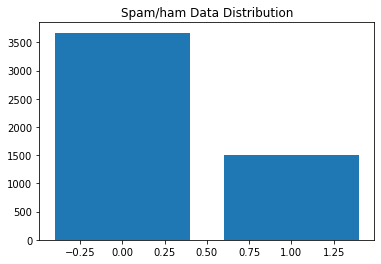

In [12]:
plt.bar(V.index,V.values)
plt.title("Spam/ham Data Distribution")

In [13]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re


In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [15]:
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [16]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
df.text = df.text.apply(lambda x: preprocess(x))


In [18]:
df.head()

,text,label_num
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: : indian springs deal book teco pvr r...,0


In [19]:
pip install wordcloud


In [20]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600 , height = 800).generate(" ".join(df[df.label_num == 1].text))

<Figure size 1440x1440 with 0 Axes>

Text(0.5, 1.0, 'Spam Word Cloud')

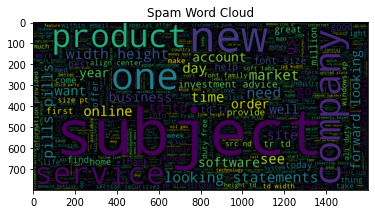

In [21]:
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

Text(0.5, 1.0, 'Ham Word Cloud')

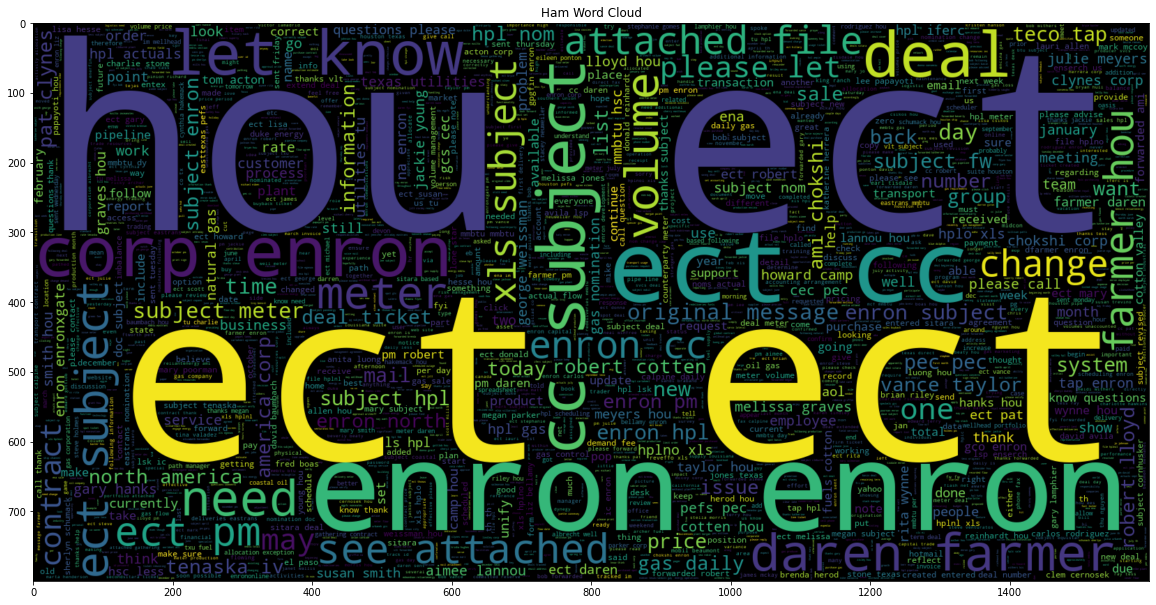

In [22]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label_num == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Ham Word Cloud")

In [23]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

In [24]:
X = df['text']
y = df['label_num']

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=10)

TOKENIZATION

In [27]:
from keras.preprocessing.text import Tokenizer

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
word_index = tokenizer.word_index

In [30]:
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 45464


In [31]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (4136,)
Testing X Shape: (1035,)


In [32]:
x_train

array([[    0,     0,     0, ...,    79,    19,     5],
       [  627,     5,    41, ...,    31,  1241,   264],
       [    0,     0,     0, ...,  2716,    24,   450],
       ...,
       [20218,   876,   986, ...,   234,  1812,   389],
       [    0,     0,     0, ...,    32,    63,   138],
       [    0,     0,     0, ...,   110,    10,   479]], dtype=int32)

**LSTM**

In [33]:
n_lstm = 200
drop_lstm =0.2

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [35]:
embeding_dim = 16

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [47]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [48]:
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test),callbacks =[early_stop], verbose=2)

Epoch 1/30
130/130 - 2s - loss: 1.2022e-04 - accuracy: 1.0000 - val_loss: 0.1822 - val_accuracy: 0.9752
Epoch 2/30
130/130 - 2s - loss: 8.7835e-05 - accuracy: 1.0000 - val_loss: 0.1906 - val_accuracy: 0.9749
Epoch 3/30
130/130 - 2s - loss: 7.5321e-05 - accuracy: 1.0000 - val_loss: 0.1948 - val_accuracy: 0.9746
Epoch 4/30
130/130 - 2s - loss: 7.3795e-05 - accuracy: 1.0000 - val_loss: 0.1999 - val_accuracy: 0.9742
Epoch 5/30
130/130 - 2s - loss: 7.6231e-05 - accuracy: 1.0000 - val_loss: 0.2154 - val_accuracy: 0.9729
Epoch 6/30
130/130 - 2s - loss: 5.7499e-05 - accuracy: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9731
Epoch 7/30
130/130 - 2s - loss: 6.1531e-05 - accuracy: 1.0000 - val_loss: 0.2261 - val_accuracy: 0.9727
Epoch 8/30
130/130 - 2s - loss: 5.2815e-05 - accuracy: 1.0000 - val_loss: 0.2305 - val_accuracy: 0.9726
Epoch 9/30
130/130 - 2s - loss: 3.3487e-04 - accuracy: 1.0000 - val_loss: 0.1673 - val_accuracy: 0.9785
Epoch 10/30
130/130 - 2s - loss: 8.2586e-05 - accuracy: 1.0000 -

In [49]:
metrics = pd.DataFrame(history.history)

In [52]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.000120,1.000000,0.182151,0.975208
1,0.000088,1.000000,0.190597,0.974879
2,0.000075,1.000000,0.194831,0.974589
3,0.000074,1.000000,0.199867,0.974203
4,0.000076,0.999995,0.215411,0.972870
5,0.000057,0.999995,0.219279,0.973101
6,0.000062,0.999995,0.226112,0.972696
7,0.000053,1.000000,0.230504,0.972599
8,0.000335,0.999952,0.167320,0.978473
9,0.000083,0.999981,0.166799,0.979169


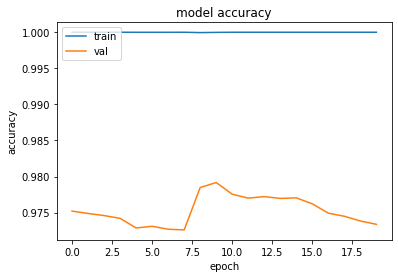

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
y_pred = model.predict(x_test)
y_pred.shape

(1035, 50, 1)

In [61]:
from tensorflow.keras.models import load_model

model.save('bilstm.h5')

In [62]:
from google.colab import files
files.download("bilstm.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>